# Nail Disease Classifier V1

# Efficient Netv2 model

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

in_colab = True

if in_colab:
    DATA_DIR = Path("/content/drive/MyDrive/Nail disease detection/data/")
else:
    DATA_DIR = Path("data/")

Mounted at /content/drive


In [3]:
import torch, torchvision, torchmetrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Data Preparation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from torchvision import datasets, transforms as T


TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
VALID_DIR = DATA_DIR / "valid"

RANDOM_SEED = 0

In [6]:
# Plotting random images
import random
from PIL import Image

def plot_images(data_dir: Path,
                transforms: T=None,
                random_seed: int=None):
    random.seed(random_seed)

    image_path_list = list(data_dir.glob("*/*/*.jpg"))
    fig = plt.figure(figsize=(10,7))
    rows, cols = 3, 3

    for i in range(1, rows * cols + 1):
        random_img_path = random.choice(image_path_list)
        img_class = random_img_path.parent.stem
        fig.add_subplot(rows, cols, i)
        random_img = Image.open(random_img_path)

        if transforms:
            transformed_img = transforms(random_img)
            plt.imshow(transformed_img.permute(1, 2, 0))
        else:
            plt.imshow(random_img)
        plt.title(f"{img_class} ({random_img.height}, {random_img.width})")
        plt.axis(False)


### Raw images

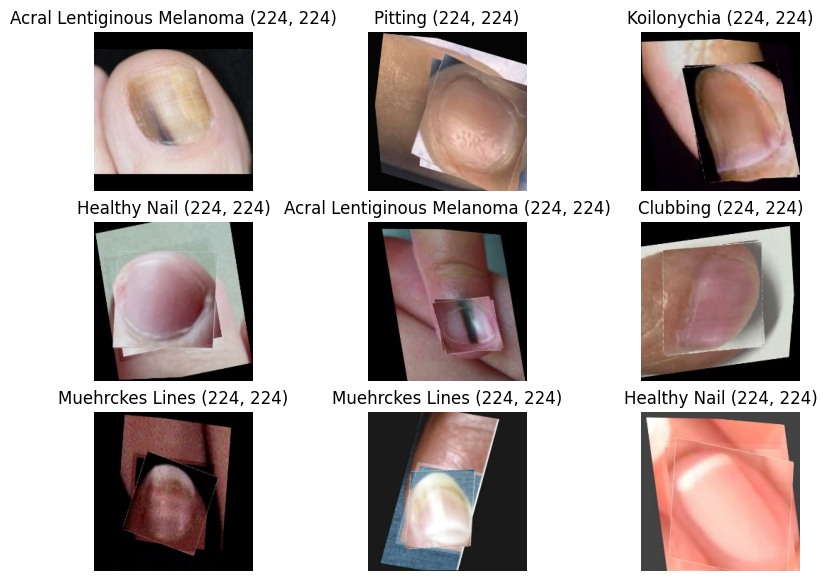

In [7]:
plot_images(data_dir=DATA_DIR, random_seed=RANDOM_SEED)

### Transforms

In [8]:
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### Transformed Images

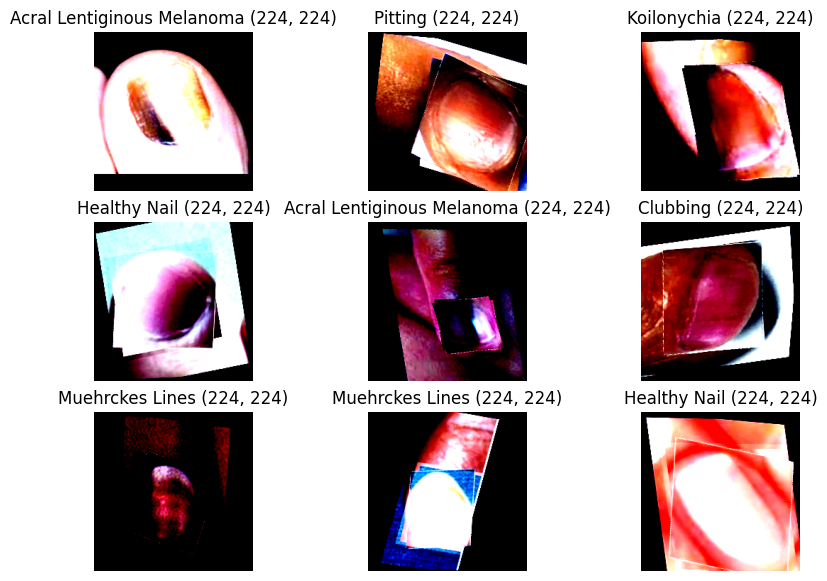

In [9]:
plot_images(data_dir=DATA_DIR, transforms=transform, random_seed=RANDOM_SEED)

In [10]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=TEST_DIR,
                                  transform=transform,
                                  target_transform=None)

valid_data = datasets.ImageFolder(root=VALID_DIR,
                                  transform=transform,
                                  target_transform=None)

class_names = train_data.classes

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Valid data length: {len(valid_data)}")
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: \n{class_names}")

Train data length: 6360
Test data length: 307
Valid data length: 591
Number of Classes: 10
Class Names: 
['Acral Lentiginous Melanoma', 'Beaus Line', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting', 'Terry-s Nail']


### Data Loader

In [11]:
from torch.utils.data import DataLoader

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 199 batches of 32
Test dataloader: 10 batches of 32
Valid dataloader: 19 batches of 32


In [12]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model Building

In [13]:
import torchvision.models as models
from torchmetrics import Accuracy
from torch import nn

model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

# Change the output layer to be 10 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.001)
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 169MB/s]


Check the model's device

In [14]:
next(model.parameters()).device

device(type='cuda', index=0)

## Training the Model

In [16]:
import helper_functions
import gc

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

EPOCHS = 5
model_results = helper_functions.train_model(epochs=EPOCHS, model=model,
                            train_dataloader=train_dataloader,
                            valid_dataloader=valid_dataloader,
                            criterion=criterion,
                            optimizer=optimizer,
                            accuracy_fn=accuracy_fn,
                            device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0 / 6360 samples
Looked at 320 / 6360 samples
Looked at 640 / 6360 samples
Looked at 960 / 6360 samples
Looked at 1280 / 6360 samples
Looked at 1600 / 6360 samples
Looked at 1920 / 6360 samples
Looked at 2240 / 6360 samples
Looked at 2560 / 6360 samples
Looked at 2880 / 6360 samples
Looked at 3200 / 6360 samples
Looked at 3520 / 6360 samples
Looked at 3840 / 6360 samples
Looked at 4160 / 6360 samples
Looked at 4480 / 6360 samples
Looked at 4800 / 6360 samples
Looked at 5120 / 6360 samples
Looked at 5440 / 6360 samples
Looked at 5760 / 6360 samples
Looked at 6080 / 6360 samples
Epoch: 0 | Train loss: 1.1265, Train accuracy : 0.6358 | Valid loss: 0.9829, Valid accuracy: 0.7054
Looked at 0 / 6360 samples
Looked at 320 / 6360 samples
Looked at 640 / 6360 samples
Looked at 960 / 6360 samples
Looked at 1280 / 6360 samples
Looked at 1600 / 6360 samples
Looked at 1920 / 6360 samples
Looked at 2240 / 6360 samples
Looked at 2560 / 6360 samples
Looked at 2880 / 6360 samples
Looked at 32

## Saving weights

In [21]:
import pandas as pd
DIR_NAME = "results"
FILE_NAME = "efficient_net_v2_s"
results_file = helper_functions.save_results(dir_name=DIR_NAME,
                                             file_name=FILE_NAME,
                                             results=model_results)

df = helper_functions.load_results(dir_name=DIR_NAME,
                                   file_name=FILE_NAME,
                                   run="latest")

## Plotting results

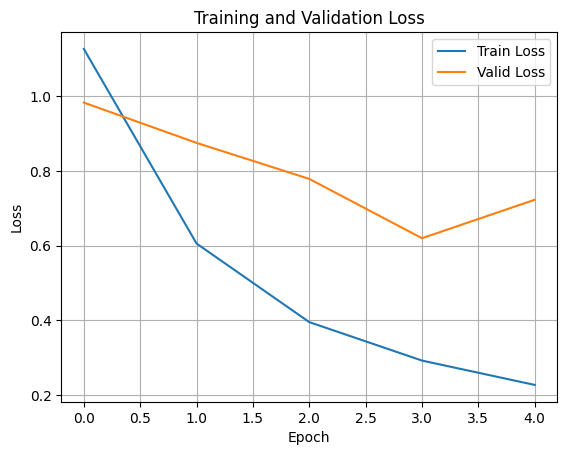

In [22]:
plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
df

,train_loss,train_acc,valid_loss,valid_acc
0,1.126537,0.635835,0.982910,0.705373
1,0.605657,0.806794,0.875054,0.766228
2,0.395272,0.870394,0.778623,0.772368
3,0.292333,0.903790,0.619846,0.825219
4,0.227175,0.921116,0.722797,0.797040


## Saving the Model

In [23]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
FILE_NAME = "efficient_net_v2_s.pth"

MODEL_SAVE_PATH = MODEL_PATH / FILE_NAME

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving to models/vgg_16_epoch_15.pth


## Making predictions

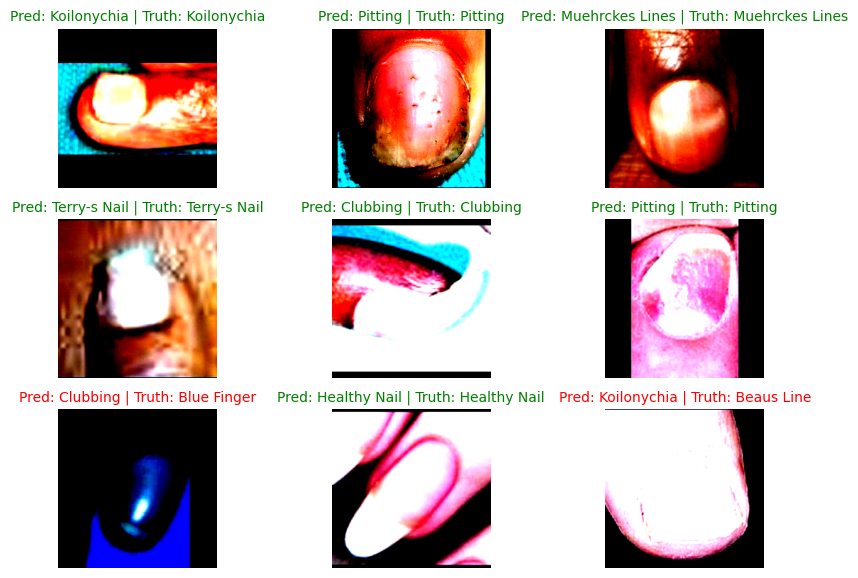

In [24]:
helper_functions.predict_compare(test_data=test_data,
                                 model=model,
                                 device=device,
                                 class_names=class_names,
                                 random_seed=RANDOM_SEED)

## Confusion Matrix

In [26]:
from tqdm.auto import tqdm
y_preds = []

model.eval()
with torch.inference_mode():
    for X, y, in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds)
y_true = torch.tensor(test_data.targets)
y_preds

Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 7, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 2, 2, 1, 9, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3,
        2, 2, 2, 3, 2, 2, 2, 3, 6, 2, 3, 2, 2, 2, 2, 3, 3, 6, 1, 3, 9, 9, 5, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 1, 3, 3, 6, 3, 3, 3, 4, 3, 3,
        3, 3, 3, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 5, 4, 4, 4, 4,
        4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 0, 5, 3, 5, 1, 3, 5, 1,
        1, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 5, 7, 7, 8, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 8, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 7, 7, 6, 7, 7, 8, 8, 8, 8, 8, 3, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 5, 6, 8, 1, 3, 8, 1, 4, 8, 8, 8, 8, 8, 8,
        8, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 4, 9, 9, 9, 5, 9, 6,
        9, 9, 4, 9, 1, 1, 9, 9, 4, 9, 9,

In [27]:
len(y_preds), len(y_true)

(307, 307)

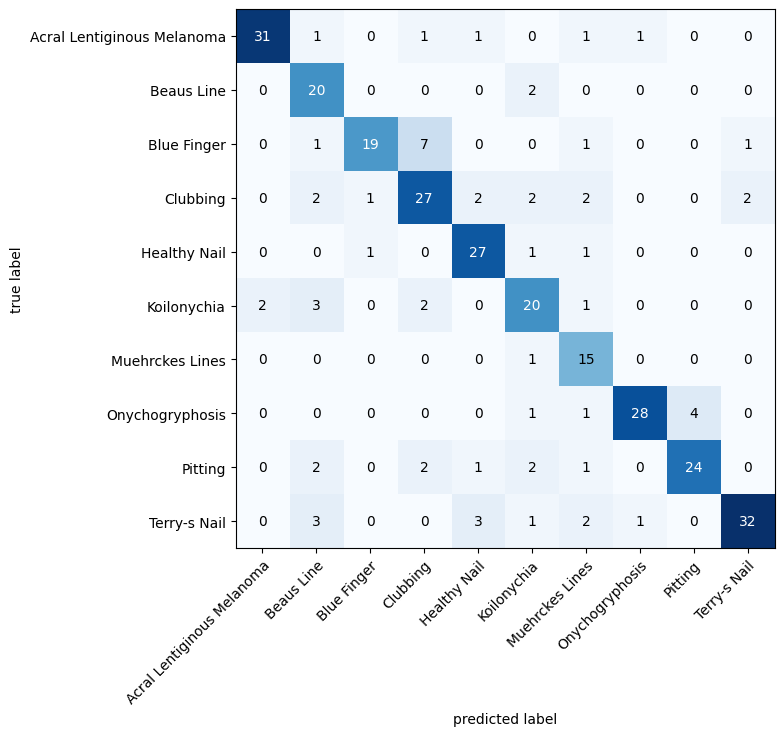

In [28]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10,7))

## Classification Report

In [29]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=class_names)
print(report)

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.86      0.94      0.90        33
                Beaus Line       0.91      0.62      0.74        32
               Blue Finger       0.66      0.90      0.76        21
                  Clubbing       0.71      0.69      0.70        39
              Healthy Nail       0.90      0.79      0.84        34
               Koilonychia       0.71      0.67      0.69        30
           Muehrckes Lines       0.94      0.60      0.73        25
           Onychogryphosis       0.82      0.93      0.88        30
                   Pitting       0.75      0.86      0.80        28
              Terry-s Nail       0.76      0.91      0.83        35

                  accuracy                           0.79       307
                 macro avg       0.80      0.79      0.79       307
              weighted avg       0.80      0.79      0.79       307



In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_pred=y_preds, y_true=y_true)
prec = precision_score(y_pred=y_preds, y_true=y_true, average='macro')
rec = recall_score(y_pred=y_preds, y_true=y_true, average='macro')
f1 = f1_score(y_pred=y_preds, y_true=y_true, average='macro')

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.79
Precision: 0.79
Recall: 0.80
F1 Score: 0.79
